In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2

In [2]:
already_merged=True

# fmcw_data_dir = '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc'
fmcw_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
starttimestring = '201704302000'
endtimestring = '201704302359'

if not already_merged:
    filepaths = fmcw.get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring, subdirs=False)
    print(filepaths)

    # Read in multifile FMCW dataset
    fmcw_merged_dataset = fmcw.read_fmcw_multifile_xarray(filepaths)
    # Dealias
    fmcw_merged_dataset = fmcw.dealias(fmcw_merged_dataset)
    fmcw_merged_dataset.load()
    
else:    
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_data_dir, fmcw_filename)
    fmcw_merged_dataset = xr.open_dataset(fmcw_filepath)

print(fmcw_merged_dataset)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 1112, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * time      (time) datetime64[ns] 2017-04-30T20:03:45 ... 2017-05-01T00:00:46
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
Data variables:
    Zef       (time, height, vels) float64 ...
    sf        (time, height, vels) int16 ...
    sn        (time, height) int16 ...
    sff       (time, height, vels) int16 ...
    snr       (time, height) float64 ...
    Ze        (time, height) float64 ...
    vel       (time, height) float32 ...
    wid       (time, height) float32 ...
    vel_da    (time, height) float64 ...
    Ze_corr   (time, height) float64 ...
    Zef_corr  (time, height, vels) float64 ...
Attributes:
    NetCDFRevision:  UMass MIRSL FMCW V1.0
    RadarName:       UMa-FMCW
    PRF:             287.224
    Frequency:       2945000000.0
    Latitude:        34.6872
    Longitude:       -86.00

In [3]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.load_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 49, parameter: 3, time: 1441)
Coordinates:
  * time                                 (time) datetime64[ns] 2017-04-30T00:00:03 ... 2017-05-01T00:00:03
    fallspeed                            (fallspeed_bin) float64 0.05 ... 20.8
    diameter                             (diameter_bin) float64 0.0625 ... 24.5
    min_diameter                         (diameter_bin) float64 0.0 ... 23.0
    max_diameter                         (diameter_bin) float64 0.125 ... 26.0
    min_fallspeeds                       (fallspeed_bin) float64 0.0 ... 19.2
    max_fallspeeds                       (fallspeed_bin) float64 0.1 ... 22.4
  * parameter                            (parameter) object 'N0' 'lamda' 'alpha'
  * fields_KHTX                          (fields_KHTX) object 'N0_TMM_F' ... 'RR_TMM_F'
  * fallspeed_bin                        (fallspeed_bin) float64 0.05 ... 20.8
  * diameter_bin      

In [4]:
PIPS_ds.load()
PIPS_new_file = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s_new.nc'
PIPS_new_filepath = os.path.join(PIPS_data_dir, PIPS_new_file)
PIPS_ds.to_netcdf(PIPS_new_filepath)

In [5]:
print(PIPS_ds['KHTX_beam_height_at_PIPS'])

<xarray.DataArray 'KHTX_beam_height_at_PIPS' (time: 1441)>
array([         nan, 628.19267882, 633.11455382, ...,          nan,
                nan,          nan])
Coordinates:
  * time           (time) datetime64[ns] 2017-04-30T00:00:03 ... 2017-05-01T00:00:03
    flagged_times  (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    radar_name:       KHTX
    PIPS_name:        PIPS2A
    PIPS_x:           7199.980248152492
    PIPS_y:           -27066.28414821541
    elevation_angle:  0.5


In [6]:
%matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
# fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset)
fmcw_merged_resampled_ds = fmcw_merged_dataset.resample(time='10S').interpolate()
print(fmcw_merged_resampled_ds)
fmcw_merged_ds_rolling = fmcw_merged_resampled_ds.rolling(time=6)
fmcw_merged_resampled_ds = fmcw_merged_ds_rolling.mean()
print(fmcw_merged_resampled_ds)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 1423, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-04-30T20:03:40 ... 2017-05-01T00:00:40
Data variables:
    Zef       (time, height, vels) float64 nan nan nan ... -99.0 -99.0 -44.15
    sf        (time, height, vels) float64 nan nan nan ... -379.4 -384.2 -369.6
    sn        (time, height) float64 nan nan nan nan ... -372.0 -372.5 -372.5
    sff       (time, height, vels) float64 nan nan nan ... -379.4 -384.2 -369.6
    snr       (time, height) float64 nan nan nan ... -0.03077 -0.2846 -0.3769
    Ze        (time, height) float64 nan nan nan nan ... -7.831 -8.131 -8.223
    vel       (time, height) float64 nan nan nan ... -0.1437 -0.06646 -0.0907
    wid       (time, height) float64 nan nan nan nan ... 3.107 3.04 3.084 3.12
    vel_da    (time, height) float64 nan nan

In [7]:
fmcw_merged_resampled_at_PIPS_ds = fmcw_merged_resampled_ds.interp_like(PIPS_ds)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 1441, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-04-30T00:00:03 ... 2017-05-01T00:00:03
Data variables:
    Zef       (time, height, vels) float64 nan nan nan ... -92.58 -69.41 -70.02
    sf        (time, height, vels) float64 nan nan nan ... -379.3 -377.8 -376.0
    sn        (time, height) float64 nan nan nan nan ... -373.4 -374.7 -374.2
    sff       (time, height, vels) float64 nan nan nan ... -379.3 -377.8 -376.0
    snr       (time, height) float64 nan nan nan nan ... -2.627 -2.455 -2.841
    Ze        (time, height) float64 nan nan nan nan ... -10.53 -10.35 -10.69
    vel       (time, height) float64 nan nan nan ... -0.06831 -0.0007983 0.03859
    wid       (time, height) float64 nan nan nan nan ... 3.577 3.538 3.518 3.555
    vel_da    (time, height) float64 

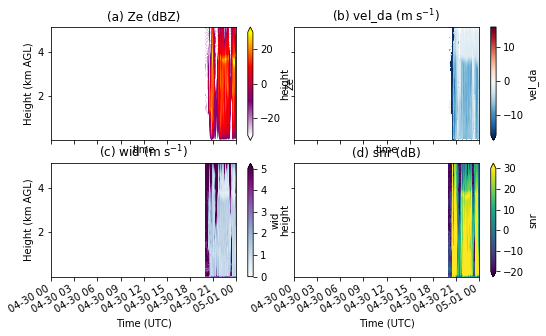

In [8]:
fmcw_merged_resampled_at_PIPS_ds.attrs = fmcw_merged_dataset.attrs
print(fmcw_merged_resampled_at_PIPS_ds)
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_resampled_at_PIPS_ds)

In [9]:
if not already_merged:
    fmcw_merged_dataset = fmcw.correct_fmcw_with_nexrad(fmcw_merged_dataset, PIPS_ds, radar_name='KHTX', 
                                                        dBZ_field='REF', plot=True)
    print(fmcw_merged_dataset['Ze'])
    print(fmcw_merged_dataset['Ze_corr'])
    fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset, dBZ_var='Ze_corr')
    print(fmcw_merged_dataset)
    fmcw_output_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
    if not os.path.exists(fmcw_output_dir):
        os.makedirs(fmcw_output_dir)
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_output_dir, fmcw_filename)
    fmcw_merged_dataset.to_netcdf(fmcw_filepath)

(1441, 32)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


<xarray.DataArray 'height' ()>
array(500.)
Coordinates:
    height   float64 500.0
<xarray.DataArray 'Ze_corr' (time: 1112)>
array([-11.892619, -11.792619, -15.092619, ...,   6.107381,   4.607381,
         1.607381])
Coordinates:
    height   float64 500.0
  * time     (time) datetime64[ns] 2017-04-30T20:03:45 ... 2017-05-01T00:00:46
Attributes:
    bias:     22.307381434890807
start_datetime 2017-04-30 20:00:00
end_datetime 2017-04-30 23:59:00


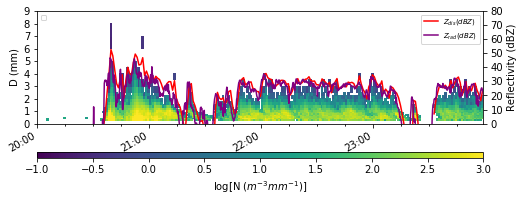

In [10]:
import pyPIPS.parsivel_params as pp
import pyPIPS.polarimetric as dp
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
bin_width = max_diameter - min_diameter
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']
min_fall_bins = pp.parsivel_parameters['min_fallspeed_bins_mps']
max_fall_bins = pp.parsivel_parameters['max_fallspeed_bins_mps']
avg_fall_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']

vd_matrix_da = PIPS_ds['VD_matrix_qc']
ND = PIPS_ds['ND_qc']
logND = np.log10(ND)

# conv_df = pips.calc_thermo(conv_df)
# # empirical_fallspeed = pips.calc_empirical_fallspeed(avg_diameter)
# fallspeed_spectrum = pips.calc_fallspeed_spectrum(avg_diameter, avg_fall_bins, correct_rho=True,
#                                                   rho=conv_df['rho'])
# vd_matrix_da = vd_matrix_da.where(vd_matrix_da > 0.0)
# ND = pips.calc_ND(vd_matrix_da, fallspeed_spectrum, 10.)
# ND = ND.T
# logND = np.log10(ND)
# logND = 

PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)

PSD_edgetimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_edges'])
PSD_centertimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_centers'])

# ND = PIPS_dict['ND'].T
# logND = ma.log10(ND)
# DSD_index = PIPS_dict['DSD_index']
# DSD_interval = PIPS_dict['DSD_interval']
# DSD_interval_td = timedelta(seconds=DSD_interval)
# DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
# PSDtimestamps = PIPS_dict['PSDtimestamps']
# PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

# pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

# pstarttime = PSDtimestampsnums[pstartindex]
# pstoptime = PSDtimestampsnums[pstopindex]

# plotstarttime = pstarttime
# plotstoptime = pstoptime

# PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# # Add an extra 10 sec for the last time bin boundary
# PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
# PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
# PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
# PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/dawson29/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dp.calpolrain(15.0, scattfile, ND, bin_width)
#print(dualpol_dis)
dis_ref = dualpol_dis.get('REF', np.empty((0)))
logND_plot = logND.T
disvars = {'min_diameter': min_diameter, 'PSDstarttimes': PSD_edgetimes,
           'PSDmidtimes': PSD_centertimes, 'logND': logND_plot}
disvars['REF'] = dis_ref

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[0]):
    temp_M6 = ((avg_diameter[:] / 1000.)**6.) * (1000. * ND[t, :]) * bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
#disvars['dBZ'] = refl_disd

# fig, ax = plt.subplots(figsize=(8, 3))

# ax.plot(PSD_centertimes, disvars['dBZ'])

radz = 500. # (m) Height of FMCW gate to plot
radzindex = int(radz/5.)

plotx_rad = fmcw_merged_dataset['time'].values
#dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex] + 10.**(2.*7.3/10.)
dBZ_D_plt = fmcw_merged_dataset['Ze_corr'].values[:, radzindex]


print(fmcw_merged_dataset['height'][radzindex])
print(fmcw_merged_dataset['Ze_corr'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'REF': dBZ_D_plt}

# Prepare axis parameters
# timelimits = [md.date2num(datetime.strptime(starttimestring, tm.timefmt3)),
#               md.date2num(datetime.strptime(endtimestring, tm.timefmt3))]
# timelimits = [md.date2num(datetime.strptime('20170430203000', tm.timefmt3)),
#               md.date2num(datetime.strptime('20170430210000', tm.timefmt3))]
# Set up axis parameters
start_time = '20170430200000'
end_time = '20170430235900'
try:
    start_datetime = datetime.strptime(start_time, tm.timefmt3)
    print('start_datetime', start_datetime)
except (ValueError, TypeError):
    start_datetime = PSD_edgetimes[0]
try:
    end_datetime = datetime.strptime(end_time, tm.timefmt3)
    print('end_datetime', end_datetime)
except (ValueError, TypeError):
    end_datetime = PSD_edgetimes[-1]
timelimits = [start_datetime, end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=1)
minorlocator = md.MinuteLocator(byminute=[0,15,30,45])
# minorlocator = md.HourLocator(interval=1)
#dateformat = '%d/%H'
dateformat = '%H:%M'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)

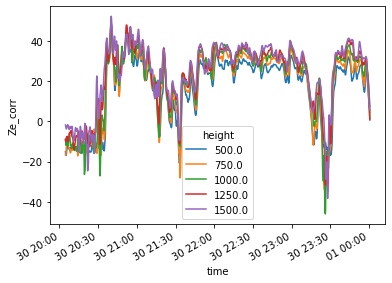

In [11]:
dBZ_D_plt = fmcw_merged_resampled_ds['Ze_corr']
dBZ_D_plt.sel(height=[500., 750., 1000., 1250., 1500.]).plot.line(x='time')

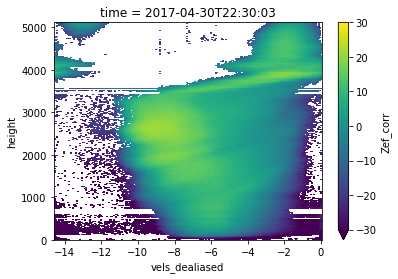

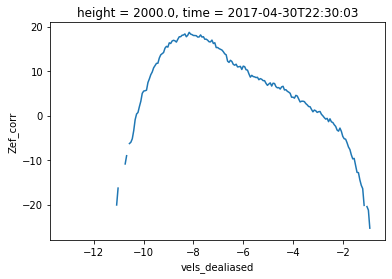

In [12]:
vbins = fmcw_merged_resampled_at_PIPS_ds['vels']
vbins_dealias = vbins - vbins[-1]
fmcw_merged_resampled_at_PIPS_ds.coords['vels_dealiased'] = ('vels', vbins_dealias)
#print(fmcw_merged_resampled_at_PIPS_ds)
Zef_corr = fmcw_merged_resampled_at_PIPS_ds['Zef_corr']
#print(Zef_corr)
#print(Zef_corr.loc['2017-04-30T22:30':'2017-04-30T22:31'])
Zef_corr_2230 = Zef_corr.sel(time='2017-04-30T22:30:03')
# print(Zef_corr_2230)
Zef_corr_2230 = Zef_corr_2230.roll(vels=128, roll_coords=False)
#delta_v = Zef_corr_2230.vels[1] - Zef_corr_2230.vels[0]
#print(2. / delta_v)
#shift = int(2. / delta_v)
#Zef_corr_2230_shifted = Zef_corr_2230.roll(vels=shift, roll_coords=False)
Zef_corr_2230_z2000 = Zef_corr_2230.sel(height=2000.)
Zef_corr_2230.plot(x='vels_dealiased', y='height', vmin=-30, vmax=30)
#fig2, ax2 = plt.subplots()
#Zef_corr_2230_shifted.plot(ax=ax2, vmin=-30, vmax=30)
fig, ax = plt.subplots()
Zef_corr_2230_z2000.plot(ax=ax, x='vels_dealiased')

#Zef_corr_2230.plot(vmin=0., vmax=40.)

In [ ]:
snr

             x  g
0    64.038123  A
1    66.147050  B
2    66.370011  C
3    68.791019  D
4    70.583534  E
..         ... ..
495  69.358022  F
496  72.212877  G
497  70.474247  H
498  73.251022  I
499  74.461828  J

[500 rows x 2 columns]
      height      vels                time  vels_dealiased   Zef_corr
0        1.0 -7.314703 2017-04-30 22:30:03      -14.572260        NaN
1        1.0 -7.257557 2017-04-30 22:30:03      -14.515114        NaN
2        1.0 -7.200410 2017-04-30 22:30:03      -14.457968        NaN
3        1.0 -7.143264 2017-04-30 22:30:03      -14.400822        NaN
4        1.0 -7.086119 2017-04-30 22:30:03      -14.343676        NaN
...      ...       ...                 ...             ...        ...
2811  5000.0  7.028972 2017-04-30 22:30:03       -0.228585 -11.431366
2812  5000.0  7.086119 2017-04-30 22:30:03       -0.171438 -21.127187
2813  5000.0  7.143264 2017-04-30 22:30:03       -0.114293 -14.647073
2814  5000.0  7.200410 2017-04-30 22:30:03       -0.057147  

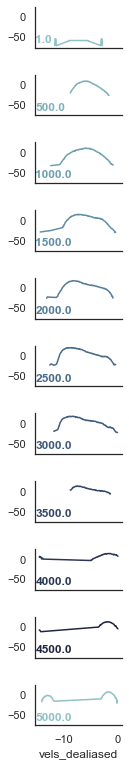

In [13]:
# Let's make a ridge plot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

print(df)


Zef_corr_2230_thinned = Zef_corr_2230.thin({'height': 100})

Zef_corr_2230_df = Zef_corr_2230_thinned.to_dataframe().reset_index()
print(Zef_corr_2230_df)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(Zef_corr_2230_df, row="height", hue='height', aspect=2, height=1., palette=pal)

# Draw the densities in a few steps
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, color="w", lw=2, bw=.2)
g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, alpha=1, lw=1.5)
#g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, color="w", lw=2, bw=.2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "vels_dealiased")

# Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=True)

             x  g
0    64.038123  A
1    66.147050  B
2    66.370011  C
3    68.791019  D
4    70.583534  E
..         ... ..
495  69.358022  F
496  72.212877  G
497  70.474247  H
498  73.251022  I
499  74.461828  J

[500 rows x 2 columns]


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


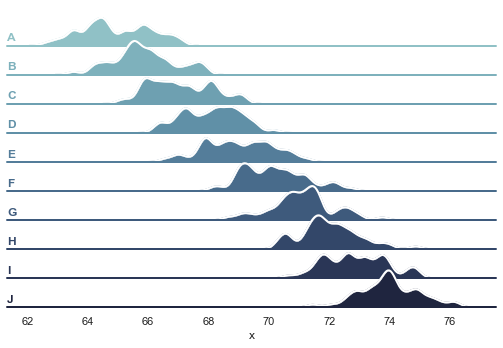

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
print(df)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)